In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

In [3]:
# 1. Load data
df = pd.read_csv(r"C:\Users\sanke\Downloads\Crop_recommendation.csv")  # or path where you stored the dataset

In [4]:
# 2. Basic preprocessing
# (Check for missing values, outliers, etc.)
print(df.isna().sum())
# (Here, this dataset should have no missing values.)


N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [5]:
# 3. Encode label (crop) as integer
le = LabelEncoder()
df['crop_id'] = le.fit_transform(df['label'])
X = df.drop(['label', 'crop_id'], axis=1)
y = df['crop_id']

In [6]:
# 4. Train / validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
# 5. Choose model & hyperparameters (XGBoost)
xgb_clf = xgb.XGBClassifier(
    objective = 'multi:softprob',
    num_class = len(le.classes_),
    eval_metric = "mlogloss",
    use_label_encoder=False,
    n_estimators = 200,
    max_depth = 6,
    learning_rate = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
)


In [8]:
# 6. (Optional) Use calibration to get better probability estimates
# You can wrap the model with CalibratedClassifierCV (e.g. with “sigmoid” or “isotonic”)
# But calibrating with many classes can be tricky; you can calibrate only after selecting a good base model.
calibrated = CalibratedClassifierCV(xgb_clf, method='sigmoid', cv=5)

In [9]:
calibrated.fit(X_train, y_train)

C:\Users\sanke\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\sanke\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:02:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\sanke\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:02:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\sanke\anaconda3\Lib\site-packages\

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.8,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='mlogloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=6,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=200, n_jobs=None,
                                               num_class=22,
                                               num_parallel_tree=None, ...))

In [10]:
# 8. Evaluate on the test set
y_pred = calibrated.predict(X_test)
print("Accuracy on test:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy on test: 0.9931818181818182
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.91      1.00      0.95        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00 

In [11]:
# 9. Inspect predicted probabilities
proba = calibrated.predict_proba(X_test)  # shape (n_samples, n_classes)
max_proba = np.max(proba, axis=1)
predicted_labels = np.argmax(proba, axis=1)

In [12]:
# 10. Choose a confidence threshold and assign “Healthy / Unhealthy”
threshold = 0.70  # you can tune this
health_status = np.where(max_proba >= threshold, "Healthy", "Unhealthy")

In [13]:
# 11. Add these to a results DataFrame
res_df = X_test.copy()
res_df = res_df.reset_index(drop=True)
res_df['true_crop'] = le.inverse_transform(y_test.reset_index(drop=True))
res_df['pred_crop'] = le.inverse_transform(predicted_labels)
res_df['max_proba'] = max_proba
res_df['health_status'] = health_status

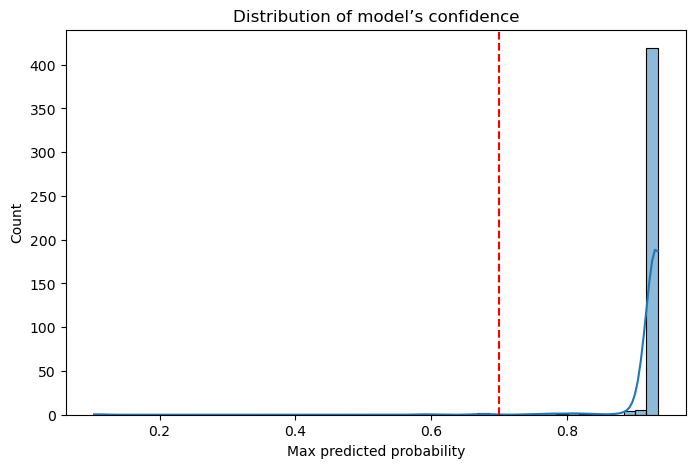

In [14]:

# 12. Analyze the distribution of max_proba to choose threshold
plt.figure(figsize=(8,5))
sns.histplot(max_proba, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--')
plt.xlabel("Max predicted probability")
plt.ylabel("Count")
plt.title("Distribution of model’s confidence")
plt.show()

In [15]:
# 13. (Optional) Save the model & label encoder
joblib.dump(calibrated, "soil_health_xgb_calibrated.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [16]:
# 14. Function to classify a new sample
def classify_soil(sample_dict, model, label_encoder, threshold=0.70):
    """
    sample_dict: dict of feature_name -> value, e.g. {'N':50, 'P':30, …}
    """
    feat_df = pd.DataFrame([sample_dict])
    probs = model.predict_proba(feat_df)[0]
    max_p = np.max(probs)
    pred = np.argmax(probs)
    pred_crop = label_encoder.inverse_transform([pred])[0]
    status = "Healthy" if max_p >= threshold else "Unhealthy"
    return {
        "pred_crop": pred_crop,
        "confidence": max_p,
        "health_status": status,
        "all_probs": dict(zip(label_encoder.classes_, probs))
    }

In [20]:
def classify_soil_with_crop(sample_dict, model, label_encoder, threshold=0.70):
    """
    Classifies soil as Healthy/Unhealthy and suggests the most suitable crop if healthy.
    """
    import numpy as np
    import pandas as pd

    # Convert input to dataframe
    feat_df = pd.DataFrame([sample_dict])

    # Predict probabilities for all crops
    probs = model.predict_proba(feat_df)[0]
    max_prob = np.max(probs)
    pred_crop = label_encoder.inverse_transform([np.argmax(probs)])[0]

    # Decision based on threshold
    if max_prob >= threshold:
        print(f"✅ The soil is HEALTHY — suitable for planting.")
        print(f"🌾 Recommended Crop: {pred_crop}")
    else:
        print(f"⚠️ The soil is UNHEALTHY — not suitable for planting any known crop.")



In [22]:
new_sample = {
    "N": 90,
    "P": 42,
    "K": 43,
    "temperature": 25.0,
    "humidity": 80.0,
    "ph": 6.5,
    "rainfall": 200.0
}

classify_soil_with_crop(new_sample, calibrated, le, threshold=0.7)



✅ The soil is HEALTHY — suitable for planting.
🌾 Recommended Crop: jute


In [23]:
unhealthy_sample = {
    "N": 5,
    "P": 2,
    "K": 1,
    "temperature": 10.0,
    "humidity": 20.0,
    "ph": 9.5,
    "rainfall": 10.0
}

classify_soil_with_crop(unhealthy_sample, calibrated, le, threshold=0.7)


⚠️ The soil is UNHEALTHY — not suitable for planting any known crop.
